# 为“音色无关转录”任务创建数据集
目标是音色尽量丰富，训练时不使用音色混合。本文件使用的是stride=256的CQT。训练结果为最终的basicamt模型。

In [ ]:
# 总文件夹
output_dir = 'multi_large_256'

# 基本配置
instrument = [
    0, 1, 2, 6, 7,
    8, 10, 14,
    19, 21, 22,
    24, 25, 30, 38,
    40, 42, 44, 46, 48,
    53, 54,
    56, 60, 61,
    66, 68, 71,
    72, 77,
    81, 88, 98
]   # 33种乐器
midi_num = 252
octave_weight = [1, 3, 5, 6, 5, 3, 1]
frames = 900

do_CQT = False
# CQT配置
import tomllib
with open('../../model/config.toml', 'br') as f:
    CQTconfig = tomllib.load(f)['CQT']
s_per_frame = CQTconfig['hop'] / CQTconfig['fs']
piece_len = frames * s_per_frame
print(s_per_frame, piece_len)


0.011609977324263039 10.448979591836736


In [ ]:
# 总文件夹
output_dir = 'multi_medium_256'

# 基本配置
instrument = [
    0, 1, 2, 6, 7,
    8, 10, 14,
    19, 21,
    24, 25, 30,
    42, 44, 46, 48,
    53, 54,
    56, 60, 61,
    66, 68, 71,
    72, 77,
    81, 88, 98
]   # 30种乐器
midi_num = 24
octave_weight = [1, 3, 5, 6, 5, 3, 1]
frames = 900

do_CQT = False
# CQT配置
import tomllib
with open('../../model/config.toml', 'br') as f:
    CQTconfig = tomllib.load(f)['CQT']
s_per_frame = CQTconfig['hop'] / CQTconfig['fs']
piece_len = frames * s_per_frame
print(s_per_frame, piece_len)


0.011609977324263039 10.448979591836736


In [ ]:
# 总文件夹
output_dir = 'piano_medium_short_256'

# 基本配置
instrument = [0, 1, 2, 3, 4, 5]
midi_num = 30
octave_weight = [1, 3, 5, 6, 5, 3, 1]
frames = 360

do_CQT = True
# CQT配置
import tomllib
with open('../../model/config.toml', 'br') as f:
    CQTconfig = tomllib.load(f)['CQT']
s_per_frame = CQTconfig['hop'] / CQTconfig['fs']
piece_len = frames * s_per_frame
print(s_per_frame, piece_len)

In [1]:
# 总文件夹
output_dir = 'piano_large_short_256'

# 基本配置
instrument = [0, 1, 2, 3, 4, 5]
midi_num = 300
octave_weight = [1, 3, 5, 6, 5, 3, 1]
frames = 360

do_CQT = True
# CQT配置
import tomllib
with open('../../model/config.toml', 'br') as f:
    CQTconfig = tomllib.load(f)['CQT']
s_per_frame = CQTconfig['hop'] / CQTconfig['fs']
piece_len = frames * s_per_frame
print(s_per_frame, piece_len)

0.011609977324263039 4.179591836734694


In [2]:
import os
from gen import Notes
import numpy as np
import torchaudio
import sys
sys.path.append('..')
from fluidsynth import Synth
sys.path.append('../..')
from utils.midiarray import numpy2midi, midi_randomize
from utils.wavtool import cutWave
from model.CQT import CQTsmall
from model.layers import EnergyNorm

In [3]:
generator = Notes(
    octave_weight = octave_weight,
    len_range = (4, 135),
    len_mean = 32,
    len_sigma = -1
)
s = Synth(CQTconfig['fs'], gain = 0.7)
cqt = CQTsmall(
    CQTconfig['fs'],
    fmin=CQTconfig['fmin'],
    octaves=CQTconfig['octaves'],
    bins_per_octave=CQTconfig['bins_per_octave'],
    hop=CQTconfig['hop'],
    filter_scale=CQTconfig['filter_scale'],
    requires_grad=False
)
norm = EnergyNorm(output_type=0)

In [4]:
# 乐器分类
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

for inst in instrument:
    sub_dir = os.path.join(output_dir, f"inst{inst}")
    if not os.path.exists(sub_dir):
        os.mkdir(sub_dir)
    for midi_id in range(midi_num):
        np_name = os.path.join(sub_dir, f"{midi_id}.npy")
        midi_name = os.path.join(sub_dir, f"{midi_id}.mid")
        wav_name = os.path.join(sub_dir, f"{midi_id}.wav")

        np_midi = generator.generate(frames, 0.17, 0.5)
        np.save(np_name, np_midi)
        midi_randomize(
            numpy2midi(np_midi, s_per_frame, time_first=False, random=True, instrument=inst),
            velocity_range=(46, 120),
            pitch_range=(-1000, 1000),
        ).save(midi_name)
        s.midi2audio(midi_name, wav_name)
        if do_CQT:
            # 生成CQT
            cqt_name = os.path.join(sub_dir, f"{midi_id}.cqt.npy")
            waveform, sample_rate = torchaudio.load(wav_name, normalize=True)
            waveform = waveform.unsqueeze(0)    # 增加batch维
            cqt_data = norm(cqt(waveform)).squeeze(0).numpy() # 去掉batch维 [2, 288, time]
            np.save(cqt_name, cqt_data[:, :, :frames])  # 截取前frames帧
        # 剪裁音频
        cutWave(wav_name, wav_name, 0, piece_len, mono=True)

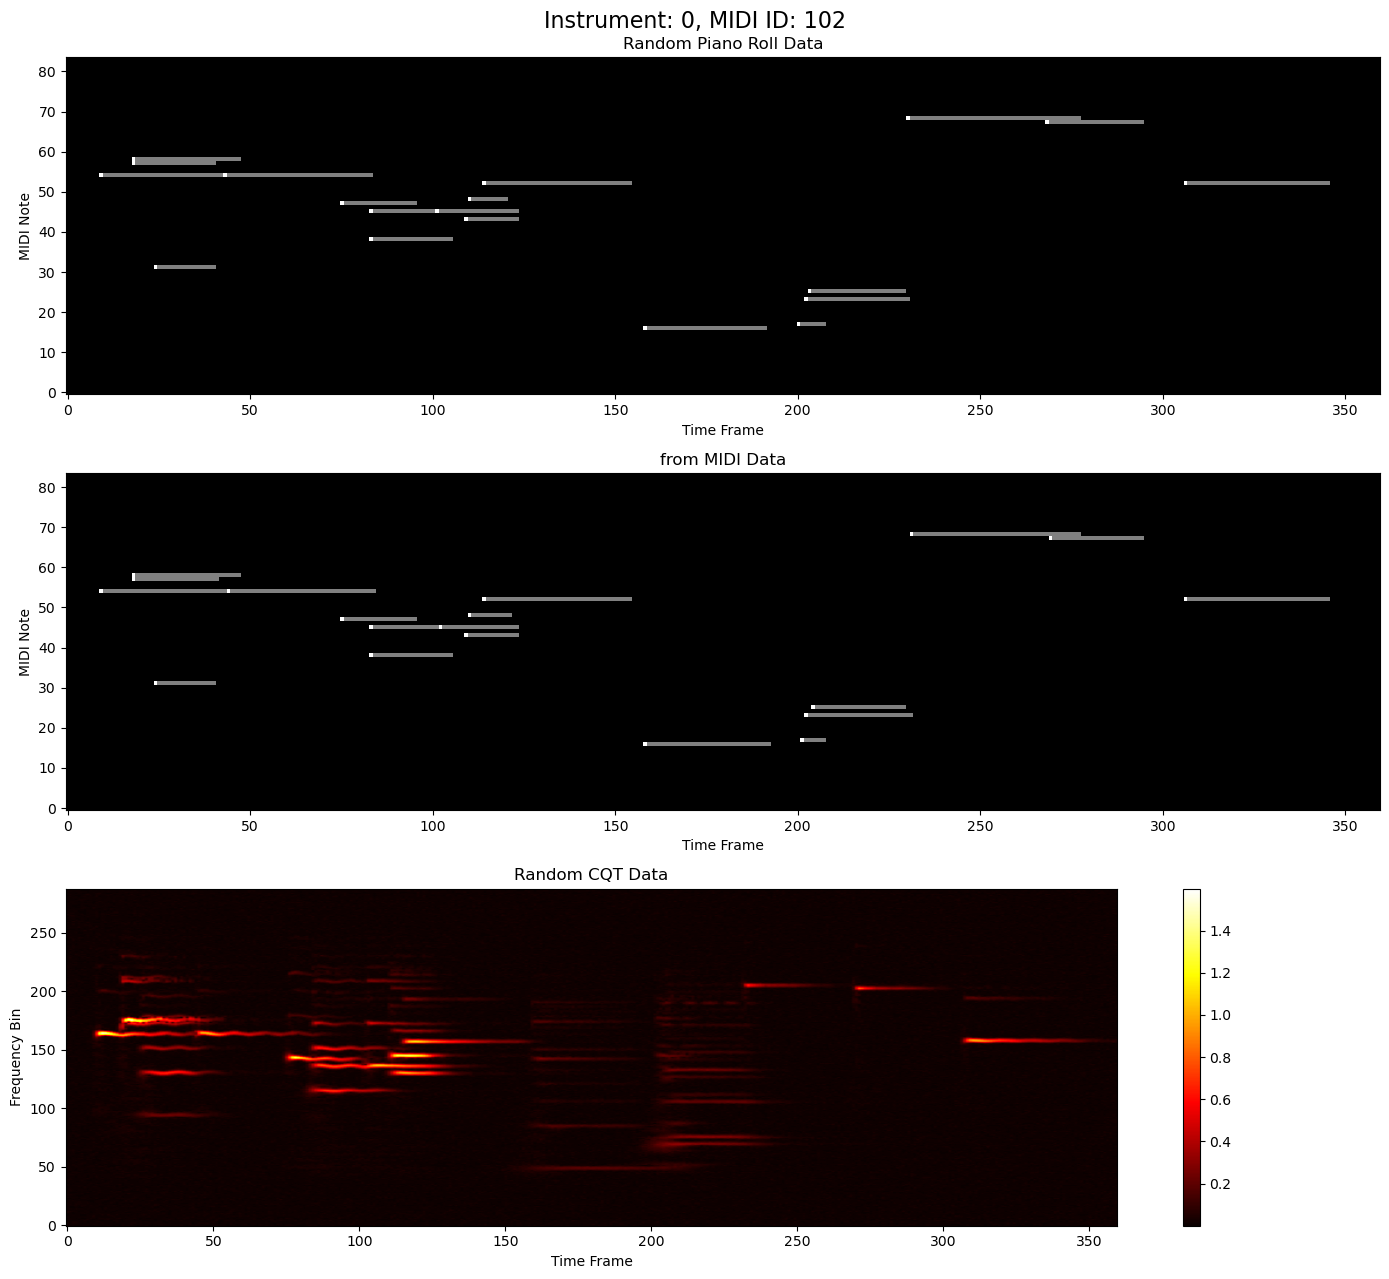

In [8]:
# 观察数据（有CQT的版本）
import matplotlib.pyplot as plt
from utils.midiarray import midi2numpy
import numpy as np

# 随机选择一个乐器和序号
random_inst = np.random.choice(instrument)
random_midi_id = np.random.randint(midi_num)

# 打开对应的npy文件
random_np_name = os.path.join(output_dir, f"inst{random_inst}", f"{random_midi_id}.npy")
random_np_midi = np.load(random_np_name)

random_cqt_name = os.path.join(output_dir, f"inst{random_inst}", f"{random_midi_id}.cqt.npy")
random_cqt = np.load(random_cqt_name)
noise = np.random.normal(0, 1, random_cqt.shape) * 0.01 # 测试加噪水平
random_cqt += noise
random_cqt = np.sqrt(random_cqt[0]**2 + random_cqt[1]**2)

random_midi_name = os.path.join(output_dir, f"inst{random_inst}", f"{random_midi_id}.mid")
frommidi = midi2numpy(random_midi_name, s_per_frame)
if frommidi.shape[1] < frames:
    padding = np.zeros((frommidi.shape[0], frames - frommidi.shape[1]))
    frommidi = np.hstack((frommidi, padding))
else:
    frommidi = frommidi[:, :frames]

# 设置总标题
plt.figure(figsize=(14, 38))
plt.suptitle(f'Instrument: {random_inst}, MIDI ID: {random_midi_id}', fontsize=16)

# 绘制random_np_midi
plt.subplot(3, 1, 1)
plt.imshow(random_np_midi, aspect='auto', origin='lower', cmap='gray')
plt.title('Random Piano Roll Data')
plt.xlabel('Time Frame')
plt.ylabel('MIDI Note')
plt.gcf().set_size_inches(14, 12)  # 设置图像大小

plt.subplot(3, 1, 2)
plt.imshow(frommidi, aspect='auto', origin='lower', cmap='gray')
plt.title('from MIDI Data')
plt.xlabel('Time Frame')
plt.ylabel('MIDI Note')
plt.gcf().set_size_inches(14, 12)  # 设置图像大小

# 绘制random_cqt
plt.subplot(3, 1, 3)
plt.imshow(random_cqt, aspect='auto', origin='lower', cmap='hot')
plt.title('Random CQT Data')
plt.xlabel('Time Frame')
plt.ylabel('Frequency Bin')
plt.gcf().set_size_inches(14, 13)  # 设置图像大小
plt.colorbar()

plt.tight_layout()
plt.show()

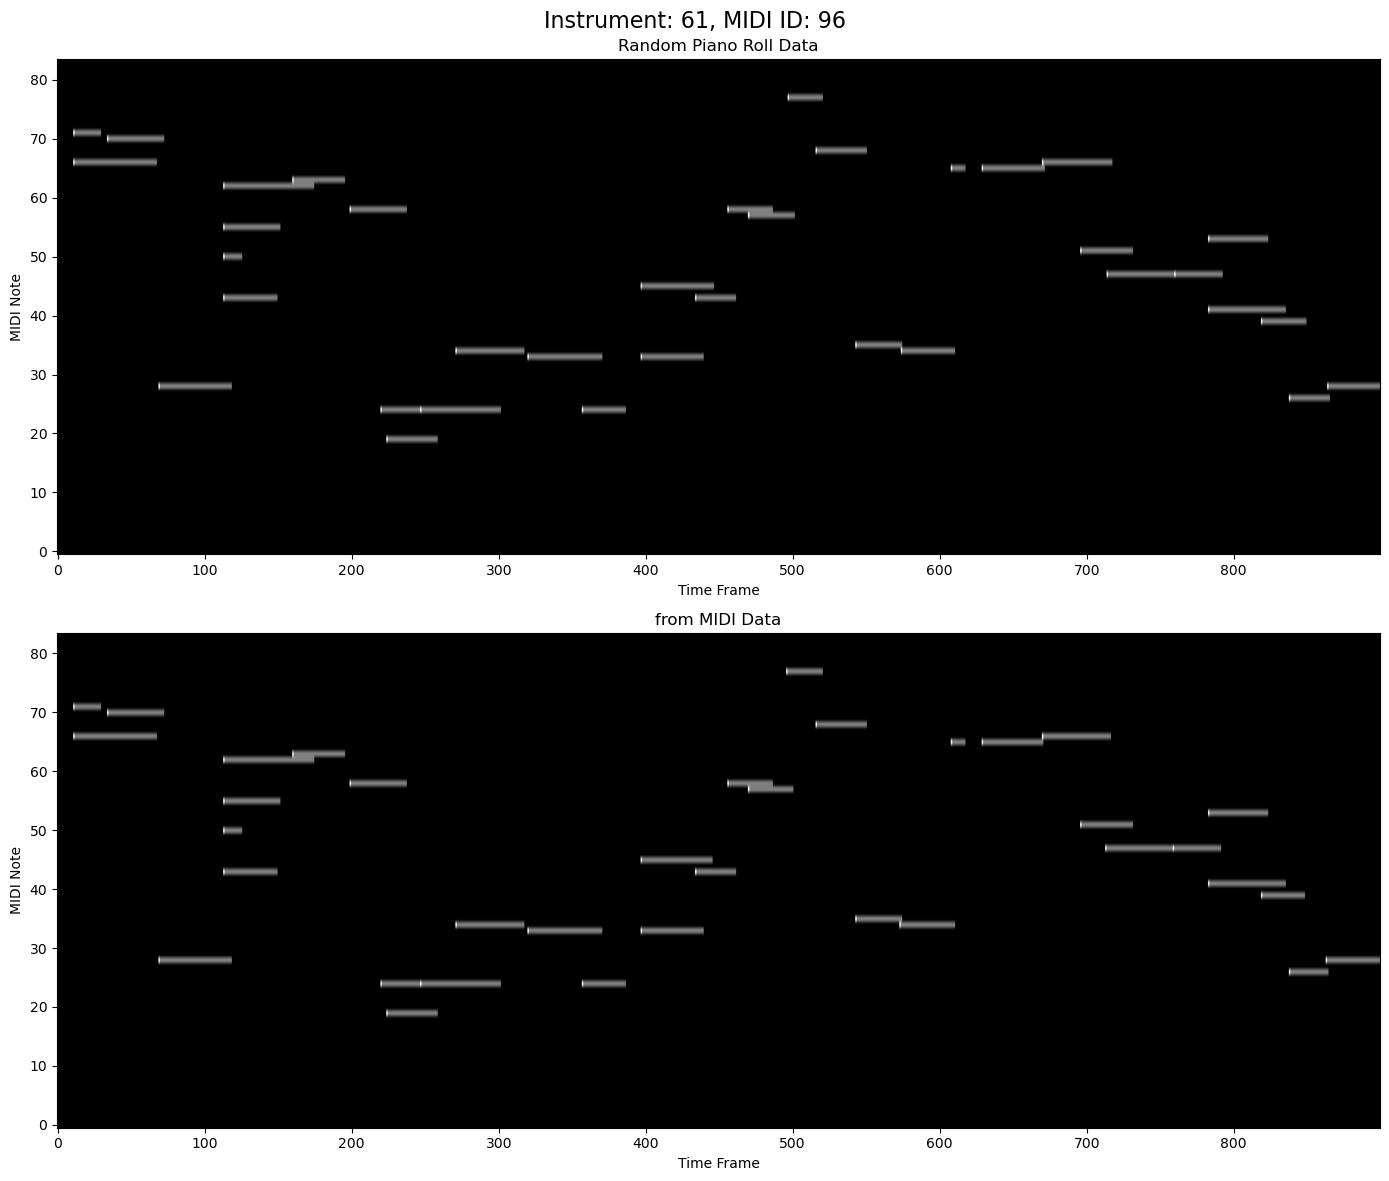

In [14]:
# 没有CQT的可视化
# 观察数据
import matplotlib.pyplot as plt
from utils.midiarray import midi2numpy
import numpy as np

# 随机选择一个乐器和序号
random_inst = np.random.choice(instrument)
random_midi_id = np.random.randint(midi_num)

# 打开对应的npy文件
random_np_name = os.path.join(output_dir, f"inst{random_inst}", f"{random_midi_id}.npy")
random_np_midi = np.load(random_np_name)

random_midi_name = os.path.join(output_dir, f"inst{random_inst}", f"{random_midi_id}.mid")
frommidi = midi2numpy(random_midi_name, s_per_frame)
if frommidi.shape[1] < frames:
    padding = np.zeros((frommidi.shape[0], frames - frommidi.shape[1]))
    frommidi = np.hstack((frommidi, padding))
else:
    frommidi = frommidi[:, :frames]

# 设置总标题
plt.figure(figsize=(14, 26))
plt.suptitle(f'Instrument: {random_inst}, MIDI ID: {random_midi_id}', fontsize=16)

# 绘制random_np_midi
plt.subplot(2, 1, 1)
plt.imshow(random_np_midi, aspect='auto', origin='lower', cmap='gray')
plt.title('Random Piano Roll Data')
plt.xlabel('Time Frame')
plt.ylabel('MIDI Note')
plt.gcf().set_size_inches(14, 12)  # 设置图像大小

plt.subplot(2, 1, 2)
plt.imshow(frommidi, aspect='auto', origin='lower', cmap='gray')
plt.title('from MIDI Data')
plt.xlabel('Time Frame')
plt.ylabel('MIDI Note')
plt.gcf().set_size_inches(14, 12)  # 设置图像大小

plt.tight_layout()
plt.show()

In [ ]:
# 主观判断加噪水平
import torchaudio
from IPython.display import Audio

# 打开对应的音频文件
random_wav_name = os.path.join(output_dir, f"inst{random_inst}", f"{random_midi_id}.wav")
# 读取音频文件
waveform, sample_rate = torchaudio.load(random_wav_name, normalize=True)

# 加上高斯噪声
noise = np.random.normal(0, 0.003, waveform.shape)
waveform_noisy = waveform + noise

# 播放音频
Audio(waveform_noisy.numpy(), rate=sample_rate)